# Sprint 3

### Goal
The goal for this sprint is develop a more complex model, and see if that performs better than your simple one.

Some questions you may want to ask:
- Can we improve upon the performance of the simple model? By how much?
- Is the more advanced model 'just' better? Or are there trade-offs?
- Can we add something other than better performance? E.g. confidence intervals?

## Imports

You know the drill: imports!

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

np.random.seed(42) # So all our results will be the same

This time, we're tidying up our code a bit, by extracting bits of functionality into functions. For you programmers out there, this is obvious, but functions allow you to take bits of code that you may want to run more frequently, and give them a name. For example:

In [2]:
def square_num(x):
    return x**2

square_num(3)

9

Above, we `def`ined a function called `square_num`, that takes a variable `x` as input, and returns that number `x` squared (`**2` is the Python way of saying "to the power 2). Next, if we call our function `square_num()` and give it the argument `3`, we can see that it returns the expected answer, `9`.

Now back to our houses!

The function below reads in our data, selects the columns we want, and splits it into a train and test set.

In [3]:
def read_and_process_data(path):
    # Training data
    train_file = 'train.csv'
    train_path = os.path.join(path, train_file)
    df_train = pd.read_csv(train_path).set_index('Id')

    # Remove columns
    selected_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'SalePrice']
    
    df_train = df_train[selected_cols]

    # Training data
    y = df_train['SalePrice']
    X = df_train.drop(['SalePrice'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, y_train, X_test, y_test

This is where things get a bit more complicated (though not much). LightGBM ([documentation](https://lightgbm.readthedocs.io/en/latest/)) is a package made by Microsoft that performs Gradient Boosting (a smart, more complicated ML method that gets excellent results on many tasks) that offers a ton of customization. Below, we define a dictionary called `lgb_params` containing the parameters we want to modify. Exactly what each of these parameters means is out of the scope of this short 'tutorial', but you can find all possible parameters you can play around with [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor).

One main advantage of LightGBM, and part of the reason we ended up using it for Huispedia, is that it can be used not only to predict point estimates, but quantiles as well. This allows us to give some measure of uncertainty when providing a house price on the website, which is something Huispedia asked for.

For now, let's run this code and train the model with the provided parameters, and see what performance we get!

In [4]:
def train_model(X_train, y_train):
    lgb_params = {'learning_rate': 0.05,
                  'max_bin': 500,
                  'min_child_samples': 10,
                  'n_estimators': 1400,
                  'num_leaves': 180}
    
    pipe_dt = Pipeline([
        ('lgbm', lgb.LGBMRegressor(**lgb_params))])  # regionale kolommen
    median = pipe_dt.set_params(lgbm__objective='quantile', lgbm__alpha=0.5).fit(X_train, np.log(y_train))

    pipe_dt = Pipeline([
        ('lgbm', lgb.LGBMRegressor(**lgb_params))])  # regionale kolommen
    lowerbound = pipe_dt.set_params(lgbm__objective='quantile', lgbm__alpha=0.2).fit(X_train, np.log(y_train))

    pipe_dt = Pipeline([
        ('lgbm', lgb.LGBMRegressor(**lgb_params))])  # regionale kolommen
    upperbound = pipe_dt.set_params(lgbm__objective='quantile', lgbm__alpha=0.8).fit(X_train, np.log(y_train))

    return lowerbound, median, upperbound

Below, we actually start running the functions we've defined above. We get our data, train a model, and get our desired quantiles as output (you can change these, if you like!).

In [5]:
X_train, y_train, X_test, y_test = read_and_process_data("../data")

lowerbound, median, upperbound = train_model(X_train, y_train)

prediction_lowerbound = np.exp(lowerbound.predict(X_test))
prediction_median = np.exp(median.predict(X_test))
prediction_upperbound = np.exp(upperbound.predict(X_test))

So let's have a look at one example:

In [6]:
print(f"This house:\n{X_test.iloc[0]}\n\nHas a true price of €{y_test.iloc[0]:.2f}\n\nWe predicted a median price of €{prediction_median[0]:.2f}\nWith a 60% certainty range of [€{prediction_lowerbound[0]:.2f}, €{prediction_upperbound[0]:.2f}]")

This house:
OverallQual       6
GrLivArea      1068
GarageCars        1
TotalBsmtSF    1059
FullBath          1
YearBuilt      1963
Name: 893, dtype: int64

Has a true price of €154500.00

We predicted a median price of €136906.50
With a 60% certainty range of [€133187.63, €145974.34]


Cool! So, sadly, the price for this particular was not exactly within our range, but it was certainly close. Now let's see how we did on all houses.

In [7]:
print(f"RMSE at median: €{np.sqrt(mean_squared_error(y_test, prediction_median)):.2f}")

RMSE at median: €29860.41


That's quite the improvement! With my settings, I ended up with an RMSE of €39710.99 with our previous, linear model. That's a 25% reduction in error! Let's see how our predictions compare to the truth.

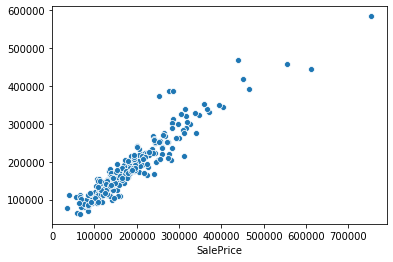

In [8]:
sns.scatterplot(y_test, prediction_median);

Excellent. We have even more of a straight line this time, and the error for more expensive houses doesn't appear to be as large as before. Let's check that again as well:

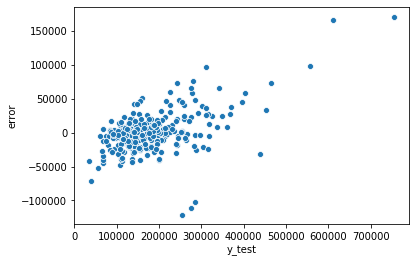

In [9]:
result = pd.DataFrame({'y_test': y_test, 'y_hat': prediction_median})
result['error'] = result['y_test'] - result['y_hat']
sns.scatterplot(result['y_test'], result['error']);

And indeed! Taking the scale of the y-axis into account, we're doing much better on the expensive houses than before (errors used to go up to aboutt €300.000,-, double the error we get now!).